<a href="https://colab.research.google.com/github/pk-790324/content-based-movie-recommendation/blob/main/content_based_filtering_movies_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1.Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import csv
from collections import defaultdict
import pickle
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
import tabulate
import warnings
warnings.filterwarnings('ignore')

<a name="2"></a>
## 2 - Movie ratings dataset
The data set is derived from the [MovieLens ml-latest-small](https://grouplens.org/datasets/movielens/latest/) dataset.

[F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4: 19:1–19:19. <https://doi.org/10.1145/2827872>]

The original dataset has roughly 9000 movies rated by 600 users with ratings on a scale of 0.5 to 5 in 0.5 step increments. The dataset has been reduced in size to focus on movies from the years since 2000 and popular genres. The reduced dataset has $n_u = 397$ users, $n_m= 847$ movies and 25521 ratings. For each movie, the dataset provides a movie title, release date, and one or more genres. For example "Toy Story 3" was released in 2010 and has several genres: "Adventure|Animation|Children|Comedy|Fantasy". This dataset contains little information about users other than their ratings. This dataset is used to create training vectors for the neural networks described below.
Let's learn a bit more about this data set. The table below shows the top 10 movies ranked by the number of ratings. These movies also happen to have high average ratings. How many of these movies have you watched?

In [2]:
top_ten_df=pd.read_csv('/content/drive/MyDrive/datasets/content-based-filtering-recomendation-datasets/content_top10_df.csv')
top_ten_df.head(10)

,movie id,num ratings,ave rating,title,genres
0,4993,198,4.106061,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy
1,5952,188,4.021277,"Lord of the Rings: The Two Towers, The",Adventure|Fantasy
2,7153,185,4.118919,"Lord of the Rings: The Return of the King, The",Action|Adventure|Drama|Fantasy
3,4306,170,3.867647,Shrek,Adventure|Animation|Children|Comedy|Fantasy|Ro...
4,58559,149,4.238255,"Dark Knight, The",Action|Crime|Drama
5,6539,149,3.778523,Pirates of the Caribbean: The Curse of the Bla...,Action|Adventure|Comedy|Fantasy
6,79132,143,4.066434,Inception,Action|Crime|Drama|Mystery|Sci-Fi|Thriller
7,6377,141,3.960993,Finding Nemo,Adventure|Animation|Children|Comedy
8,4886,132,3.871212,"Monsters, Inc.",Adventure|Animation|Children|Comedy|Fantasy
9,7361,131,4.160305,Eternal Sunshine of the Spotless Mind,Drama|Romance|Sci-Fi


The next table shows information sorted by genre. The number of ratings per genre vary substantially. Note that a movie may have multiple genre's so the sum of the ratings below is larger than the number of original ratings.

In [3]:
by_genre=pd.read_csv('/content/drive/MyDrive/datasets/content-based-filtering-recomendation-datasets/content_bygenre_df.csv')
by_genre.head(10)

,genre,num movies,ave rating/genre,ratings per genre
0,Action,321,3.37,10377
1,Adventure,234,3.42,8785
2,Animation,76,3.63,2588
3,Children,69,3.44,2472
4,Comedy,326,3.36,8911
5,Crime,139,3.54,4671
6,Documentary,13,3.81,280
7,Drama,342,3.61,10201
8,Fantasy,124,3.37,4468
9,Horror,56,3.20,1345


<a name="3"></a>
## 3 - Content-based filtering with a neural network

In the collaborative filtering lab, you generated two vectors, a user vector and an item/movie vector whose dot product would predict a rating. The vectors were derived solely from the ratings.   

Content-based filtering also generates a user and movie feature vector but recognizes there may be other information available about the user and/or movie that may improve the prediction. The additional information is provided to a neural network which then generates the user and movie vector as shown below.
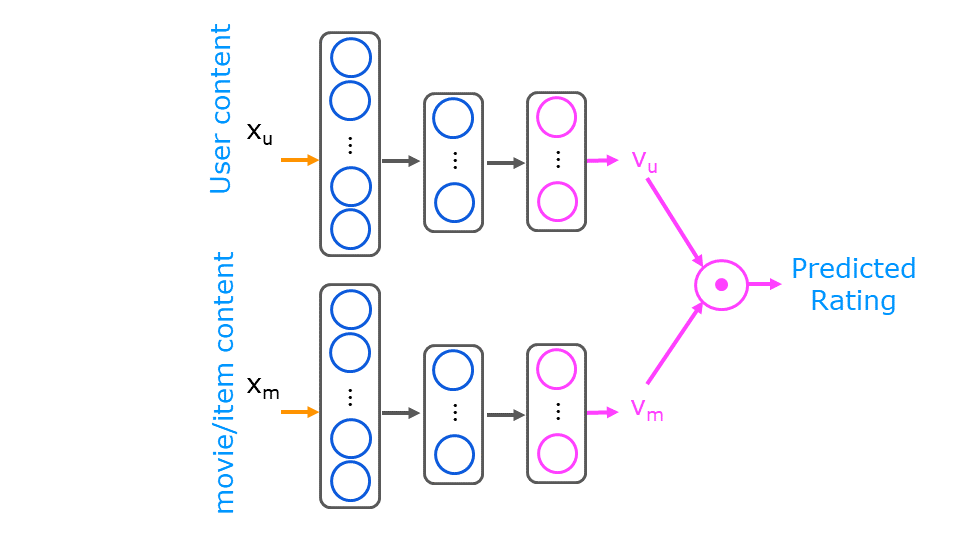

<a name="3.1"></a>
### 3.1 Training Data
The movie content provided to the network is a combination of the original data and some 'engineered features'. The original features are the year the movie was released and the movie's genre's presented as a one-hot vector. There are 14 genres. The engineered feature is an average rating derived from the user ratings.

The user content is composed of engineered features. A per genre average rating is computed per user. Additionally, a user id, rating count and rating average are available but not included in the training or prediction content. They are carried with the data set because they are useful in interpreting data.

The training set consists of all the ratings made by the users in the data set. Some ratings are repeated to boost the number of training examples of underrepresented genre's. The training set is split into two arrays with the same number of entries, a user array and a movie/item array.  

Below, let's load and display some of the data.

In [4]:
#load data
def load_data():
  #genfromtxt convert csv file to numpy and also handle missing values
  #delimiter: columns are separated by commas
  #quotechar:text inside quotechar(double quotes) is treated as one value
  #Opens the CSV file in read mode
  #with ensures the file is automatically closed
  #newline='' is recommended for CSV files to avoid blank lines (Windows issue)
  item_train=np.genfromtxt('/content/drive/MyDrive/datasets/content-based-filtering-recomendation-datasets/content_item_train.csv',delimiter=',')
  user_train=np.genfromtxt('/content/drive/MyDrive/datasets/content-based-filtering-recomendation-datasets/content_user_train.csv',delimiter=',')
  y_train=np.genfromtxt('/content/drive/MyDrive/datasets/content-based-filtering-recomendation-datasets/content_y_train.csv',delimiter=',')
  item_vector=np.genfromtxt('/content/drive/MyDrive/datasets/content-based-filtering-recomendation-datasets/content_item_vecs.csv',delimiter=',')
  with open('/content/drive/MyDrive/datasets/content-based-filtering-recomendation-datasets/content_item_train_header.txt') as f:
    #csv reader reads csv row by row
    item_features=list(csv.reader(f))[0]
    #print(item_features) #to show item(moveis features)
  with open('/content/drive/MyDrive/datasets/content-based-filtering-recomendation-datasets/content_user_train_header.txt') as f:
    user_features=list(csv.reader(f))[0]
    #print(user_features) #to show the user features
  movie_dict=defaultdict(dict)
  #default dict with dict returns empty dict when key is not matched in dictionary
  #while dict generate error when key is absent while searching key in dictionary
  count=0
  with open('/content/drive/MyDrive/datasets/content-based-filtering-recomendation-datasets/content_movie_list.csv',newline='') as f:
    reader=csv.reader(f,delimiter=',',quotechar='"')
    for i in reader:
      if count==0:
        count+=1 #skip header part
      else:
        count+=1
        movie_id=int(i[0])
        movie_dict[movie_id]['title']=i[1]
        movie_dict[movie_id]['genere']=i[2]
        #here movie_id is key for both title and genere
        #case of nested dictionary(i.e dictionary inside dictionary)
  with open('/content/drive/MyDrive/datasets/content-based-filtering-recomendation-datasets/content_user_to_genre.pickle','rb') as f:
    user_to_genere=pickle.load(f)
  return item_train,user_train,y_train,item_vector,item_features,user_features,movie_dict,user_to_genere

In [5]:
#load data
item_train,user_train,y_train,item_vector,item_features,user_features,movie_dict,user_to_genere=load_data()
#item_trian contains all item_features values like movie_id,year,....
#user_train contains all usef features values like user_id,rating count,....


In [6]:
#information about datasets
print('shape of user_train:',user_train.shape)
print('shape of item_train:',item_train.shape)
print('item features:',item_features)
print('user features:',user_features)
print('movie_dict:',movie_dict[4054])
#key as movie_id(4054) which contains title and genere
print('title of movie_id 4054 :',movie_dict[4054]['title'])

shape of user_train: (50884, 17)
shape of item_train: (50884, 17)
item features: ['movie id', 'year', 'ave rating', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller']
user features: ['user id', 'rating count', 'rating ave', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller']
movie_dict: {'title': 'Save the Last Dance (2001)', 'genere': 'Drama|Romance'}
title of movie_id 4054 : Save the Last Dance (2001)


In [7]:
#set configuration variable for training
num_user_features=user_train.shape[1]-3 #remove user_id,rating_count,rating ave at training time
num_item_features=item_train.shape[1]-1 #remove movie id at training time
uvs = 3  # user genre vector start
ivs = 3  # item genre vector start
u_s = 3  # start of columns to use in training, user
i_s = 1  # start of columns to use in training, items
print(f"Number of training vectors: {len(item_train)}")

Number of training vectors: 50884


In [8]:
print('y_train',y_train[:5])
#the target y,movies rating given by the users

y_train [4.  3.5 4.  4.  4.5]


In [9]:
#visualization of item(movies) data
pd.DataFrame(item_train,columns=[i for i in item_features]).head()

,movie id,year,ave rating,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Horror,Mystery,Romance,Sci-Fi,Thriller
0,6874.0,2003.0,3.961832,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,8798.0,2004.0,3.761364,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,46970.0,2006.0,3.250000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,48516.0,2006.0,4.252336,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,58559.0,2008.0,4.238255,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
#visualization of user data
pd.DataFrame(user_train,columns=[i for i in user_features]).head()

,user id,rating count,rating ave,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Horror,Mystery,Romance,Sci-Fi,Thriller
0,2.0,22.0,4.0,3.95,4.25,0.0,0.0,4.0,4.12,4.0,4.04,0.0,3.0,4.0,0.0,3.88,3.89
1,2.0,22.0,4.0,3.95,4.25,0.0,0.0,4.0,4.12,4.0,4.04,0.0,3.0,4.0,0.0,3.88,3.89
2,2.0,22.0,4.0,3.95,4.25,0.0,0.0,4.0,4.12,4.0,4.04,0.0,3.0,4.0,0.0,3.88,3.89
3,2.0,22.0,4.0,3.95,4.25,0.0,0.0,4.0,4.12,4.0,4.04,0.0,3.0,4.0,0.0,3.88,3.89
4,2.0,22.0,4.0,3.95,4.25,0.0,0.0,4.0,4.12,4.0,4.04,0.0,3.0,4.0,0.0,3.88,3.89


### 3.2 Preparing the training data
We'll scale the input features using the [scikit learn StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). Below, the inverse_transform is also shown to produce the original inputs. We'll scale the target ratings using a Min Max Scaler which scales the target to be between -1 and 1. [scikit learn MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [11]:
#splitting the data into train and test
#input data
item_train_data,item_test_data=train_test_split(item_train,test_size=0.20,shuffle=True,random_state=42)
user_train_data,user_test_data=train_test_split(user_train,test_size=0.20,shuffle=True,random_state=42)
#output data
y_train_data,y_test_data=train_test_split(y_train,test_size=0.20,shuffle=True,random_state=42)

#applying standardscaler to input features and minmax scaler to target feature
input_scaler=StandardScaler()
target_scaler=MinMaxScaler((-1,1)) #default 0 to 1
item_train_data=input_scaler.fit_transform(item_train_data)
item_test_data=input_scaler.transform(item_test_data)
user_train_data=input_scaler.fit_transform(user_train_data)
user_test_data=input_scaler.transform(user_test_data)
y_train_data=target_scaler.fit_transform(y_train_data.reshape(-1,1))
y_test_data=target_scaler.transform(y_test_data.reshape(-1,1))

In [12]:
#the scaled and shuffled data now has a mean 0 and standard deviation 1
pd.DataFrame(user_train_data,columns=[i for i in user_features]).head()

,user id,rating count,rating ave,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Horror,Mystery,Romance,Sci-Fi,Thriller
0,-1.310149,-1.059161,1.951446,1.855013,2.028721,-3.767863,-3.466120,0.838684,1.200870,-1.246315,1.457782,1.662082,1.232499,1.289270,0.696799,1.522936,1.661380
1,-1.687056,0.170692,-0.304886,0.044928,0.132164,0.032862,0.164450,-0.025656,-0.096084,-1.246315,-0.987813,-0.221379,0.069052,0.038666,-0.108866,0.142684,-0.071030
2,1.603847,-0.083088,0.008493,-0.513322,-0.078564,0.330958,0.327622,-0.270281,0.445501,0.771118,0.317730,0.045679,-0.241201,0.260127,0.238403,-0.467533,-0.184365
3,-0.083795,-0.779353,-0.513806,-0.327239,-0.078564,0.011569,0.062468,-0.156123,0.317231,-1.246315,-0.822322,-0.024599,-0.225688,-0.795070,-0.206101,-0.351301,-1.026284
4,-1.422658,1.764944,-0.263102,0.028012,0.184846,-0.031016,0.205243,-0.090889,-0.267111,0.738839,-0.417787,0.298681,0.239691,-0.482419,-0.108866,0.215329,-0.216747


<a name="4"></a>
## 4 - Neural Network for content-based filtering
Now, let's construct a neural network as described in the figure above. It will have two networks that are combined by a dot product. You will construct the two networks. In this example, they will be identical. Note that these networks do not need to be the same. If the user content was substantially larger than the movie content, you might elect to increase the complexity of the user network relative to the movie network. In this case, the content is similar, so the networks are the same.


In [13]:
num_outputs=20
tf.random.set_seed(11)
#user neural network
user_nn=tf.keras.models.Sequential([
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_outputs)
])
#item(movies) neural network
item_nn=tf.keras.models.Sequential([
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_outputs)
])
#create the user inputs and point to the base network
input_user=tf.keras.layers.Input(shape=(num_user_features,))
vu=user_nn(input_user)
vu=tf.keras.layers.Lambda(lambda x:tf.linalg.l2_normalize(x,axis=1))(vu)
#create the item inputs and point to the base network
input_item=tf.keras.layers.Input(shape=(num_item_features,))
vm=item_nn(input_item)
vm=tf.keras.layers.Lambda(lambda x:tf.linalg.l2_normalize(x,axis=1))(vm)
#compute the dot product of the two vectors vu and vm
output=tf.keras.layers.Dot(axes=1)([vu,vm])
#specify the input and output of the model
model=tf.keras.Model([input_user,input_item],output)
#print the model summary
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 14)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 20)        │     39,316 │ input_layer[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 20)        │     39,828 │ input_layer_2[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 20)        │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 20)        │          0 │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 1)         │          0 │ lambda[0][0],     │
│                     │                   │            │ lambda_1[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 79,144 (309.16 KB)

 Trainable params: 79,144 (309.16 KB)

 Non-trainable params: 0 (0.00 B)

### Q. Why normalizations matters in Content based filtering recommender system
### Ans:By normalizing embeddings, we remove magnitude so similarity depends only on direction, allowing the model to cluster users and items by semantic alignment—this is the core principle of content-based filtering.

In [14]:
#We will use a mean squared error loss and an Adam optimizer.
tf.random.set_seed(11)
cost_function=tf.keras.losses.MeanSquaredError()
optimization=tf.keras.optimizers.Adam(learning_rate=0.01)
#compile the model
model.compile(optimizer=optimization,loss=cost_function,metrics=[tf.keras.metrics.CosineSimilarity()])

In [15]:
#call back
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

In [16]:
#fit the model
tf.random.set_seed(11)
history=model.fit([user_train_data[:,u_s:],item_train_data[:,i_s:]],y_train_data,validation_split=0.2,epochs=20,callbacks=[early_stopping])

Epoch 1/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 24s 17ms/step - cosine_similarity: 0.7191 - loss: 0.1311 - val_cosine_similarity: 0.7239 - val_loss: 0.1193
Epoch 2/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - cosine_similarity: 0.7390 - loss: 0.1152 - val_cosine_similarity: 0.7318 - val_loss: 0.1146
Epoch 3/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - cosine_similarity: 0.7436 - loss: 0.1111 - val_cosine_similarity: 0.7404 - val_loss: 0.1118
Epoch 4/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - cosine_similarity: 0.7484 - loss: 0.1085 - val_cosine_similarity: 0.7357 - val_loss: 0.1112
Epoch 5/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - cosine_similarity: 0.7538 - loss: 0.1060 - val_cosine_similarity: 0.7418 - val_loss: 0.1081
Epoch 6/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - cosine_similarity: 0.7571 - loss: 0.1040 - val_cosine_similarity: 0.7472 - val_loss: 0.1067
Epoch 7/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - cosine_similarity: 0.7554 - loss: 0.1026 - val_cosine_

Evaluate the model to determine the loss in the test data

In [17]:
history1=model.evaluate([user_test_data[:,u_s:],item_test_data[:,i_s:]],y_test_data)

319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - cosine_similarity: 0.7744 - loss: 0.0914


It is comparable to the training loss indicating the model has not substantially overfit the training data.

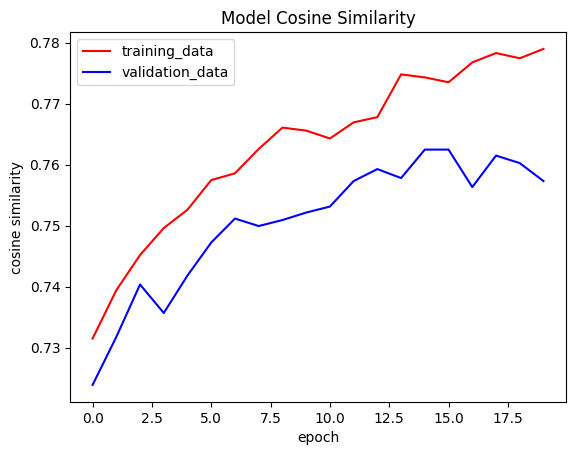

In [18]:
#visualizing accuracy and loss
plt.plot(history.history['cosine_similarity'],color='red') #accuracy of training data
plt.plot(history.history['val_cosine_similarity'],color='blue') #accuracy of test data
plt.title('Model Cosine Similarity')
plt.xlabel('epoch')
plt.ylabel('cosine similarity')
plt.legend(['training_data','validation_data'])
plt.show()

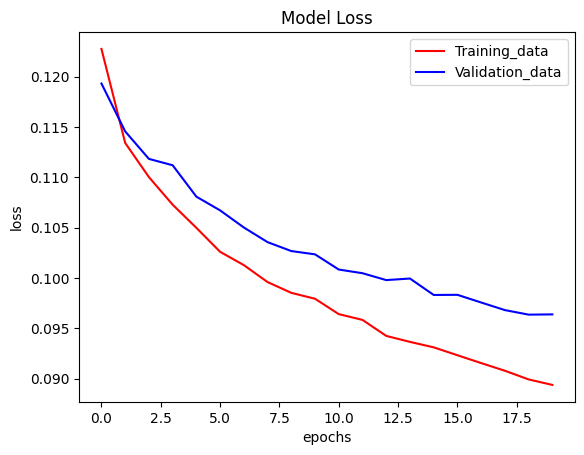

In [19]:
plt.plot(history.history['loss'],color='red') #loss of training data
plt.plot(history.history['val_loss'],color='blue') #loss of test data
plt.title('Model Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Training_data','Validation_data'])
plt.show()

<a name="5"></a>
## 5 - Predictions
Below, you'll use your model to make predictions in a number of circumstances.
<a name="5.1"></a>
### 5.1 - Predictions for a new user
First, we'll create a new user and have the model suggest movies for that user. After you have tried this on the example user content, feel free to change the user content to match your own preferences and see what the model suggests. Note that ratings are between 0.5 and 5.0, inclusive, in half-step increments.

In [20]:
new_user_id = 5000
new_rating_ave = 0.0
new_action = 0.0
new_adventure = 5.0
new_animation = 0.0
new_childrens = 0.0
new_comedy = 0.0
new_crime = 0.0
new_documentary = 0.0
new_drama = 0.0
new_fantasy = 5.0
new_horror = 0.0
new_mystery = 0.0
new_romance = 0.0
new_scifi = 0.0
new_thriller = 0.0
new_rating_count = 3

user_vector = np.array([[new_user_id, new_rating_count, new_rating_ave,
                      new_action, new_adventure, new_animation, new_childrens,
                      new_comedy, new_crime, new_documentary,
                      new_drama, new_fantasy, new_horror, new_mystery,
                      new_romance, new_scifi, new_thriller]])

The new user enjoys movies from the adventure, fantasy genres. Let's find the top-rated movies for the new user.  
Below, we'll use a set of movie/item vectors, `item_vector` that have a vector for each movie in the training/test set. This is matched with the new user vector above and the scaled vectors are used to predict ratings for all the movies.

In [21]:
pd.DataFrame(item_vector,columns=[i for i in item_features]).value_counts().head()

,,,,,,,,,,,,,,,,,count
movie id,year,ave rating,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Horror,Mystery,Romance,Sci-Fi,Thriller,
187593.0,2018.0,3.875000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
4054.0,2001.0,2.843750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1
4069.0,2001.0,2.909091,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
4148.0,2001.0,2.935897,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1
4149.0,2001.0,2.772727,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1


In [22]:
pd.DataFrame(item_train,columns=[i for i in item_features]).value_counts().head()

,,,,,,,,,,,,,,,,,count
movie id,year,ave rating,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Horror,Mystery,Romance,Sci-Fi,Thriller,
5669.0,2002.0,3.775862,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1160
8464.0,2004.0,3.510000,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1000
8622.0,2004.0,3.486486,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,740
4306.0,2001.0,3.867647,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,680
79132.0,2010.0,4.066434,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,572


conclusion: `item_trian` is the repeated version of the `item_vector`
where `movies id` `5669.0` is repeated `1160` times in `item_train`

In [23]:
#It duplicates a single user vector so it matches the number of items, enabling fast batch prediction.
#reason:score = user_vector ⋅ item_vector
def generate_user_vector(user_vector, num_items):
    user_vector = np.tile(user_vector, (num_items, 1))
    return user_vector

In [24]:
# generate and replicate the user vector to match the number movies in the data set.
user_vector = generate_user_vector(user_vector,len(item_vector))
# scale our user and item vectors
scaled_user = input_scaler.transform(user_vector)
scaled_item = input_scaler.transform(item_vector)

# make a prediction
user_prediction = model.predict([scaled_user[:, u_s:], scaled_item[:, i_s:]])

# unscale y prediction
user_prediction_unscaled = target_scaler.inverse_transform(user_prediction)

# sort the results, highest prediction first
sorted_index = np.argsort(-user_prediction_unscaled,axis=0).reshape(-1).tolist()  #negate to get largest rating first
sorted_rating   = user_prediction_unscaled[sorted_index]
sorted_items = item_vector[sorted_index]  #using unscaled vectors for display

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


In [25]:
def print_pred_movies(y_p, item, movie_dict, maxcount=10):
    data = []
    for i in range(0, y_p.shape[0]):
        if len(data) == maxcount:
            break
        movie_id = item[i, 0].astype(int)
        data.append([np.around(y_p[i, 0], 1), item[i, 0].astype(int), np.around(item[i, 2].astype(float), 1),
                     movie_dict[movie_id]['title'], movie_dict[movie_id]['genere']])
    # Create a DataFrame from the collected data
    df = pd.DataFrame(data, columns=["user_rating", "movie id", "rating ave", "title", "genres"])
    return df

In [26]:
print('.................................Recommendation For New Users....................................')
print_pred_movies(sorted_rating,sorted_items,movie_dict,maxcount=10)

.................................Recommendation For New Users....................................


,user_rating,movie id,rating ave,title,genres
0,3.5,7153,4.1,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy
1,3.5,122926,4.2,Untitled Spider-Man Reboot (2017),Action|Adventure|Fantasy
2,3.5,88125,3.9,Harry Potter and the Deathly Hallows: Part 2 (...,Action|Adventure|Drama|Fantasy|Mystery
3,3.4,81834,4.0,Harry Potter and the Deathly Hallows: Part 1 (...,Action|Adventure|Fantasy
4,3.4,4993,4.1,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy
5,3.4,6016,4.1,City of God (Cidade de Deus) (2002),Action|Adventure|Crime|Drama|Thriller
6,3.4,5952,4.0,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy
7,3.4,59387,4.0,"Fall, The (2006)",Adventure|Drama|Fantasy
8,3.4,5618,4.2,Spirited Away (Sen to Chihiro no kamikakushi) ...,Adventure|Animation|Fantasy
9,3.4,166528,3.9,Rogue One: A Star Wars Story (2016),Action|Adventure|Fantasy|Sci-Fi


<a name="5.2"></a>
### 5.2 - Predictions for an existing user.
Let's look at the predictions for "user 2", one of the users in the data set. We can compare the predicted ratings with the model's ratings.

The model prediction is generally within 1 of the actual rating though it is not a very accurate predictor of how a user rates specific movies. This is especially true if the user rating is significantly different than the user's genre average. You can vary the user id above to try different users. Not all user id's were used in the training set.

In [45]:
user_id=2
def get_user_details(user_train,user_id):
  # Filter user_train directly to get all rows for the user_id
  matching_user_rows = user_train[user_train[:, 0] == user_id]
  if len(matching_user_rows) > 0:
    # Return only the first matching row if available
    return matching_user_rows[0]
  else:
    return None

In [46]:
# Get user details for the specified used_id
ex_user_vector= get_user_details(user_train, user_id)
# generate and replicate the user vector to match the number movies in the data set.
ex_user_vector = generate_user_vector(ex_user_vector,len(item_vector))
# scale our user and item vectors
scaled_user_ex = input_scaler.transform(ex_user_vector)
scaled_item_ex = input_scaler.transform(item_vector)

# make a prediction
user_prediction_ex = model.predict([scaled_user_ex[:, u_s:], scaled_item_ex[:, i_s:]])

# unscale y prediction
user_prediction_unscaled_ex = target_scaler.inverse_transform(user_prediction_ex)

# sort the results, highest prediction first
sorted_index_ex= np.argsort(-user_prediction_unscaled_ex,axis=0).reshape(-1).tolist()  #negate to get largest rating first
sorted_rating_ex   = user_prediction_unscaled_ex[sorted_index_ex]
sorted_items_ex = item_vector[sorted_index_ex]  #using unscaled v

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [47]:
print('.....................................Recommendation For Existing Users..................................')
print_pred_movies(sorted_rating_ex,sorted_items_ex,movie_dict,maxcount=10)

.....................................Recommendation For Existing Users..................................


,user_rating,movie id,rating ave,title,genres
0,3.9,6016,4.1,City of God (Cidade de Deus) (2002),Action|Adventure|Crime|Drama|Thriller
1,3.9,55721,4.3,Elite Squad (Tropa de Elite) (2007),Action|Crime|Drama|Thriller
2,3.9,7153,4.1,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy
3,3.9,5064,3.8,The Count of Monte Cristo (2002),Action|Adventure|Drama|Thriller
4,3.8,98961,4.1,Zero Dark Thirty (2012),Action|Drama|Thriller
5,3.8,69481,4.1,"Hurt Locker, The (2008)",Action|Drama|Thriller
6,3.8,7090,3.9,Hero (Ying xiong) (2002),Action|Adventure|Drama
7,3.8,48774,3.9,Children of Men (2006),Action|Adventure|Drama|Sci-Fi|Thriller
8,3.8,58559,4.2,"Dark Knight, The (2008)",Action|Crime|Drama
9,3.8,7143,3.9,"Last Samurai, The (2003)",Action|Adventure|Drama


Conclusion:`User_id=2` likes more `Actin|Drama|Thriller` Movies

<a name="5.3"></a>
### 5.3 - Finding Similar Items
The neural network above produces two feature vectors, a user feature vector $v_u$, and a movie feature vector, $v_m$. These are 20 entry vectors whose values are difficult to interpret. However, similar items will have similar vectors. This information can be used to make recommendations. For example, if a user has rated "Toy Story 3" highly, one could recommend similar movies by selecting movies with similar movie feature vectors.

A similarity measure is the squared distance between the two vectors $ \mathbf{v_m^{(k)}}$ and $\mathbf{v_m^{(i)}}$ :
$$\left\Vert \mathbf{v_m^{(k)}} - \mathbf{v_m^{(i)}}  \right\Vert^2 = \sum_{l=1}^{n}(v_{m_l}^{(k)} - v_{m_l}^{(i)})^2\tag{1}$$

In [30]:
def square_distance(a,b):
  distance=np.sum(np.square(np.subtract(a,b)))
  return distance


A matrix of distances between movies can be computed once when the model is trained and then reused for new recommendations without retraining. The first step, once a model is trained, is to obtain the movie feature vector, $v_m$, for each of the movies. To do this, we will use the trained `item_NN` and build a small model to allow us to run the movie vectors through it to generate $v_m$.

In [31]:
input_item_m = tf.keras.layers.Input(shape=(num_item_features,))    # input layer
vm_m = item_nn(input_item_m)                                       # use the trained item_NN
vm_m =tf.keras.layers.Lambda(lambda x: tf.linalg.l2_normalize(x, axis=1))(vm_m) # incorporate normalization as was done in the original model
model_m = tf.keras.Model(input_item_m, vm_m)
model_m.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 20)             │        39,828 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ (None, 20)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,828 (155.58 KB)

 Trainable params: 39,828 (155.58 KB)

 Non-trainable params: 0 (0.00 B)

Once you have a movie model, you can create a set of movie feature vectors by using the model to predict using a set of item/movie vectors as input. `item_vecs` is a set of all of the movie vectors. It must be scaled to use with the trained model. The result of the prediction is a 32 entry feature vector for each movie.

In [32]:
scaled_item_vector = input_scaler.transform(item_vector)
vms = model_m.predict(scaled_item_vector[:,i_s:])
print(f"size of all predicted movie feature vectors: {vms.shape}")

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
size of all predicted movie feature vectors: (847, 20)


Let's now compute a matrix of the squared distance between each movie feature vector and all other movie feature vectors:

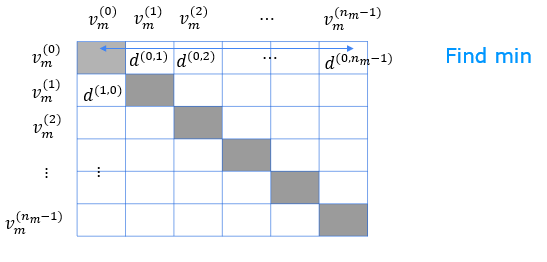

We can then find the closest movie by finding the minimum along each row. We will make use of [numpy masked arrays](https://numpy.org/doc/1.21/user/tutorial-ma.html) to avoid selecting the same movie. The masked values along the diagonal won't be included in the computation.

In [33]:
print('.............................................Similar Movies By Calculating Similar Movies Features.....................................')
import numpy.ma as ma
count = 10 # number of movies to display
dim = len(vms)
dist = np.zeros((dim,dim))

for i in range(dim):
    for j in range(dim):
        dist[i,j] = square_distance(vms[i, :], vms[j, :])

m_dist = ma.masked_array(dist, mask=np.identity(dist.shape[0]))  # mask the diagonal

disp = [["movie1", "genres", "movie2", "genres"]]
for i in range(count):
    min_idx = np.argmin(m_dist[i])
    movie1_id = int(item_vector[i,0])
    movie2_id = int(item_vector[min_idx,0])
    disp.append( [movie_dict[movie1_id]['title'], movie_dict[movie1_id]['genere'],
                  movie_dict[movie2_id]['title'], movie_dict[movie1_id]['genere']]
               )
df=pd.DataFrame(disp,columns=['movie1','genres','movie2','genres'])
df[1:]


.............................................Similar Movies By Calculating Similar Movies Features.....................................


,movie1,genres,movie2,genres
1,Save the Last Dance (2001),Drama|Romance,Mona Lisa Smile (2003),Drama|Romance
2,"Wedding Planner, The (2001)",Comedy|Romance,Mr. Deeds (2002),Comedy|Romance
3,Hannibal (2001),Horror|Thriller,Hostel (2005),Horror|Thriller
4,Saving Silverman (Evil Woman) (2001),Comedy|Romance,Cats & Dogs (2001),Comedy|Romance
5,Down to Earth (2001),Comedy|Fantasy|Romance,Bewitched (2005),Comedy|Fantasy|Romance
6,"Mexican, The (2001)",Action|Comedy,Rush Hour 2 (2001),Action|Comedy
7,15 Minutes (2001),Thriller,Panic Room (2002),Thriller
8,Enemy at the Gates (2001),Drama,"Aviator, The (2004)",Drama
9,Heartbreakers (2001),Comedy|Crime|Romance,Scary Movie 4 (2006),Comedy|Crime|Romance
10,Spy Kids (2001),Action|Adventure|Children|Comedy,Indiana Jones and the Kingdom of the Crystal S...,Action|Adventure|Children|Comedy
